In [1]:
%matplotlib notebook
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import SubsetRandomSampler
import matplotlib
from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler
from data_generator_breast import BreastPathQDataset
from data_generator_boneage import BoneAgeDataset
from data_generator_endovis import EndoVisDataset
from data_generator_oct import OCTDataset
from models import BreastPathQModel
from uce import uceloss
from calibration_plots import plot_uncert, plot_frequency, plot_uncert_multi
from utils import nll_criterion_gaussian
from glob import glob

matplotlib.rcParams['font.size'] = 8

In [2]:
base_model = 'efficientnetb4'
dataset = 'OCT'

In [3]:
assert base_model in ['resnet101', 'densenet201', 'efficientnetb4']
assert dataset in ['BreastPathQ', 'BoneAge', 'EndoVis', 'OCT']
device = torch.device("cuda:0")

base_model_caps = {
    'resnet101': 'ResNet-101',
    'densenet201': 'DenseNet-201',
    'efficientnetb4': 'EfficientNet-B4',
}

In [4]:
resize_to = (256, 256)
if dataset == 'BreastPathQ':
    batch_size = 16
    resize_to = (384, 384)
    out_channels = 1

    data_set = BreastPathQDataset(data_dir='/media/fastdata/laves/breastpathq/', augment=False, resize_to=resize_to)
    assert len(data_set) > 0

    calib_indices = torch.load('./data_indices/breastpathq_valid_indices.pth')
    test_indices = torch.load('./data_indices/breastpathq_test_indices.pth')

    print(calib_indices.shape)
    print(test_indices.shape)

    calib_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                               sampler=SubsetRandomSampler(calib_indices))
    test_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                              sampler=SequentialSampler(test_indices))
    
    model = BreastPathQModel(base_model, out_channels=1).to(device)

    checkpoint_path = glob(f"/media/fastdata/laves/regression_snapshots/{base_model}_gaussian_breastpathq.pth.tar")[0]

    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    print("Loading previous weights at epoch " + str(checkpoint['epoch']) + " from\n" + checkpoint_path)
elif dataset == 'BoneAge':
    batch_size = 16
    out_channels = 1

    data_set = BoneAgeDataset(data_dir='/media/fastdata/laves/rsna-bone-age/', augment=False, resize_to=resize_to)
    assert len(data_set) > 0

    calib_indices = torch.load('./data_indices/boneage_valid_indices.pth')
    test_indices = torch.load('./data_indices/boneage_test_indices.pth')

    print(calib_indices.shape)
    print(test_indices.shape)

    calib_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                               sampler=SubsetRandomSampler(calib_indices))
    test_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                              sampler=SubsetRandomSampler(test_indices))
    
    model = BreastPathQModel(base_model, in_channels=1, out_channels=1).to(device)

    checkpoint_path = glob(f"/media/fastdata/laves/regression_snapshots/{base_model}_gaussian_boneage.pth.tar")[0]

    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    print("Loading previous weights at epoch " + str(checkpoint['epoch']))
elif dataset == 'EndoVis':
    batch_size = 16
    out_channels = 2

    data_dir = '/media/fastdata/laves/EndoVis15_instrument_tracking'
    data_set_valid = EndoVisDataset(data_dir=data_dir+'/valid', augment=False, scale=0.5)
    data_set_test = EndoVisDataset(data_dir=data_dir+'/test', augment=False, scale=0.5)

    assert len(data_set_valid) > 0
    assert len(data_set_test) > 0
    print(len(data_set_valid))
    print(len(data_set_test))

    calib_loader = torch.utils.data.DataLoader(data_set_valid, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(data_set_test, batch_size=batch_size, shuffle=False)

    model = BreastPathQModel(base_model, out_channels=2).to(device)

    checkpoint_path = glob(f"/media/fastdata/laves/regression_snapshots/{base_model}_gaussian_endovis.pth.tar")[0]

    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    print("Loading previous weights at epoch " + str(checkpoint['epoch']) + " from\n" + checkpoint_path)
elif dataset == 'OCT':
    out_channels = 6
    batch_size = 16

    data_dir = '/media/fastdata/laves/oct_data_needle/data'
    data_set = OCTDataset(data_dir=data_dir, augment=False, resize_to=resize_to)
    assert len(data_set) > 0

    calib_indices = torch.load('./data_indices/oct_valid_indices.pth')
    test_indices = torch.load('./data_indices/oct_test_indices.pth')

    print(calib_indices.shape)
    print(test_indices.shape)

    calib_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                               sampler=SubsetRandomSampler(calib_indices))
    test_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                              sampler=SequentialSampler(test_indices))

    model = BreastPathQModel(base_model, out_channels=6).to(device)

    checkpoint_path = glob(f"/media/fastdata/laves/regression_snapshots/{base_model}_gaussian_oct.pth.tar")[0]

    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    print("Loading previous weights at epoch " + str(checkpoint['epoch']) + " from\n" + checkpoint_path)
else:
    assert False

torch.Size([850])
torch.Size([850])
Loading previous weights at epoch 499 from
/media/fastdata/laves/regression_snapshots/efficientnetb4_gaussian_oct.pth.tar


In [5]:
model.eval()
mus_calib = []
vars_calib = []
logvars_calib = []
targets_calib = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(calib_loader)):
        data, target = data.to(device), target.to(device)

        mu, logvar, var_bayesian = model(data, dropout=True, mc_dropout=True)

        mus_calib.append(mu.detach())
        vars_calib.append(var_bayesian.detach())
        logvars_calib.append(logvar.detach())
        targets_calib.append(target.detach()) 

mu_calib = torch.cat(mus_calib, dim=0).clamp(0, 1)
var_calib = torch.cat(vars_calib, dim=0)
logvar_calib = torch.cat(logvars_calib, dim=0)
target_calib = torch.cat(targets_calib, dim=0)

100%|██████████| 54/54 [01:07<00:00,  1.25s/it]


In [6]:
err_calib = torch.pow(target_calib-mu_calib, 2).sqrt()

uncertainty = 'total'

uncert_calib_aleatoric = logvar_calib.exp()
uncert_calib_epistemic = var_calib

if uncertainty == 'aleatoric':
    uncert_calib = uncert_calib_aleatoric.sqrt().clamp(0, 1)
elif uncertainty == 'epistemic':
    uncert_calib = uncert_calib_epistemic.sqrt().clamp(0, 1)
else:
    uncert_calib = (uncert_calib_aleatoric + uncert_calib_epistemic).sqrt().clamp(0, 1)  # total

In [7]:
print((err_calib**2).mean())
print((uncert_calib**2).mean())
print(uncert_calib_aleatoric.sqrt().mean())
print(uncert_calib_epistemic.sqrt().mean())

tensor(0.0015, device='cuda:0')
tensor(0.0004, device='cuda:0')
tensor(0.0144, device='cuda:0')
tensor(0.0133, device='cuda:0')


<IPython.core.display.Javascript object>


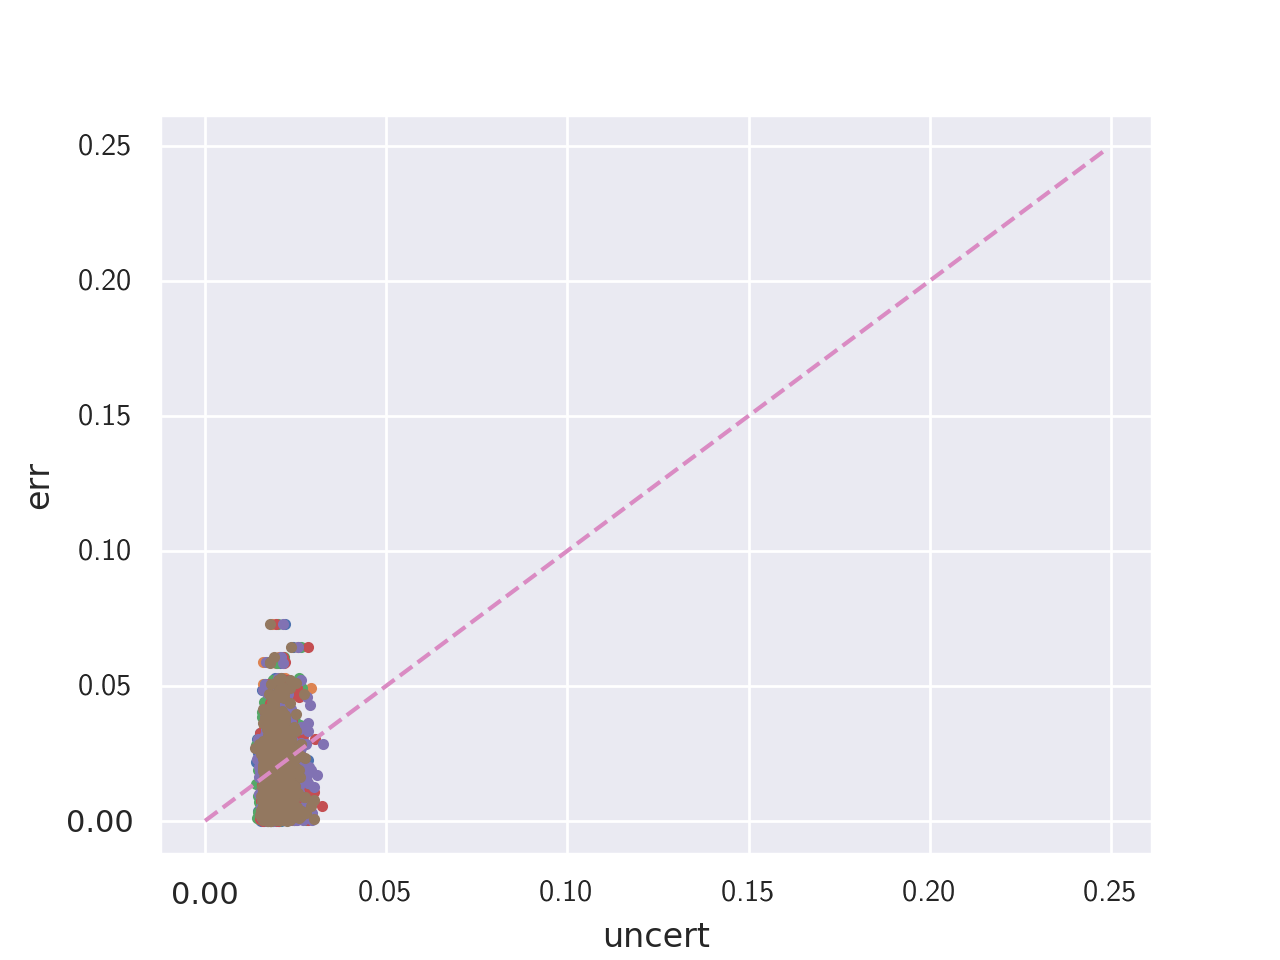

In [8]:
fig, ax = plt.subplots(1)
ax.plot(uncert_calib.cpu(), err_calib.cpu()[:,0], '.')

max_val = max(err_calib.max().item(), uncert_calib.max().item())
ax.plot([0, max_val], [0, max_val], '--')
ax.set_xlabel('uncert')
ax.set_ylabel('err')
plt.show()

In [9]:
# calculate optimal T
S = (err_calib**2 / uncert_calib**2).mean().sqrt()
print(S)

tensor(1.9323, device='cuda:0')


In [10]:
class Scaler(torch.nn.Module):
    def __init__(self, init_S=1.0):
        super().__init__()
        self.S = torch.nn.Parameter(torch.tensor([init_S]))

    def forward(self, x):
        return self.S.mul(x)

In [11]:
# find optimal S
scaler = Scaler(init_S=S).to(device)
s_opt = torch.optim.LBFGS([scaler.S], lr=3e-2, max_iter=200)

def closure():
    s_opt.zero_grad()

    loss = nll_criterion_gaussian(mu_calib, scaler(uncert_calib).pow(2).log(), target_calib)

    loss.backward()
    return loss

s_opt.step(closure)
print(scaler.S.item())

1.9527008533477783


In [12]:
class AuxModel(torch.nn.Module):
    def __init__(self, channels, hidden=16):
        super().__init__()
        self.linear1 = torch.nn.Linear(channels, hidden, bias=True)
        self.fc = torch.nn.Linear(hidden, channels, bias=True)

    def forward(self, x):
        x = 2*(x.log())
        y = self.linear1(x).relu()
        y = self.fc(y)
        
        if self.training:
            return y
        else:
            return (0.5*y).exp()

In [13]:
# find optimal aux
aux = AuxModel(out_channels).to(device)
aux_opt = torch.optim.Adam(aux.parameters(), lr=3e-3, weight_decay=0)
lr_scheduler_net = optim.lr_scheduler.ReduceLROnPlateau(aux_opt, patience=100, factor=0.1)

aux.train()
for i in range(2000):
    aux_opt.zero_grad()
    loss = nll_criterion_gaussian(mu_calib, aux(uncert_calib), target_calib)
    loss.backward()
    aux_opt.step()
    lr_scheduler_net.step(loss.item())

print(loss.item())

-5.540228366851807


In [14]:
aux.train()
print(nll_criterion_gaussian(mu_calib, uncert_calib.pow(2).log(), target_calib).item())
print(nll_criterion_gaussian(mu_calib, (S*uncert_calib).pow(2).log(), target_calib).item())
print(nll_criterion_gaussian(mu_calib, scaler(uncert_calib).pow(2).log(), target_calib).item())
print(nll_criterion_gaussian(mu_calib, aux(uncert_calib), target_calib).item())
aux.eval()

-4.036839485168457
-5.525126934051514
-5.525455474853516
-5.540229797363281


AuxModel(
  (linear1): Linear(in_features=6, out_features=16, bias=True)
  (fc): Linear(in_features=16, out_features=6, bias=True)
)

In [15]:
print(torch.nn.functional.mse_loss(uncert_calib**2, err_calib**2, reduction='sum').item())
print(torch.nn.functional.mse_loss((S*uncert_calib)**2, err_calib**2, reduction='sum').item())
print(torch.nn.functional.mse_loss(scaler(uncert_calib)**2, err_calib**2, reduction='sum').item())
print(torch.nn.functional.mse_loss(aux(uncert_calib)**2, err_calib**2, reduction='sum').item())

0.049244679510593414
0.04326901212334633
0.04328388720750809
0.04366026073694229


<IPython.core.display.Javascript object>


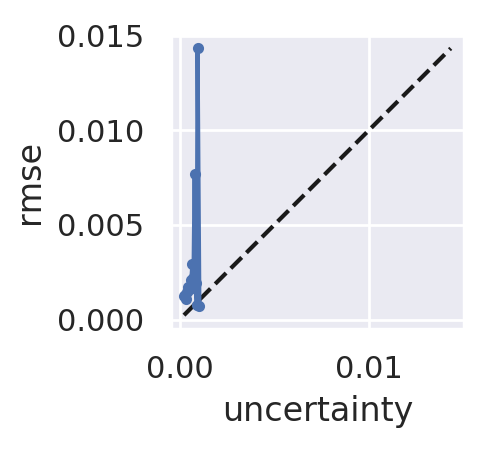

0.10585729032754898


In [16]:
uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(err_calib**2, uncert_calib**2)
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce.item()*100)
plt.show()

<IPython.core.display.Javascript object>


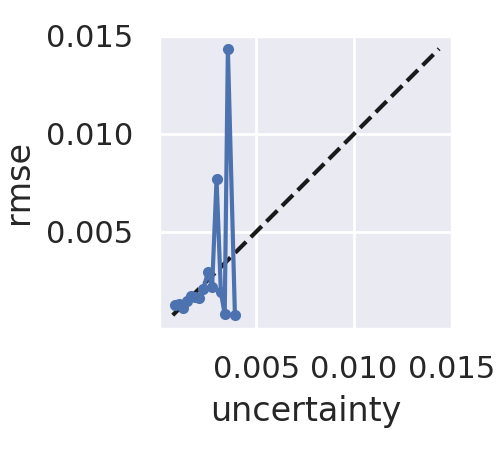

0.017450192535761744


In [17]:
uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(err_calib**2, (S*uncert_calib)**2)
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce.item()*100)
plt.show()

<IPython.core.display.Javascript object>


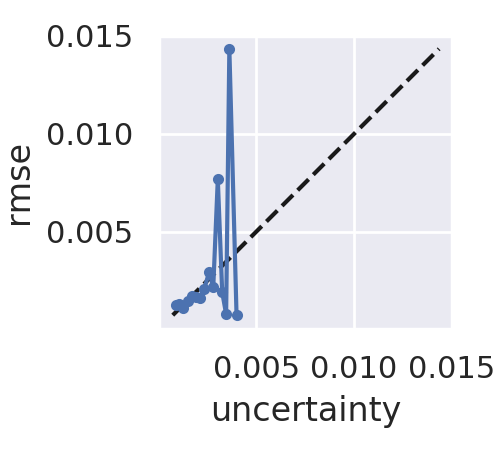

0.018578150775283575


<IPython.core.display.Javascript object>


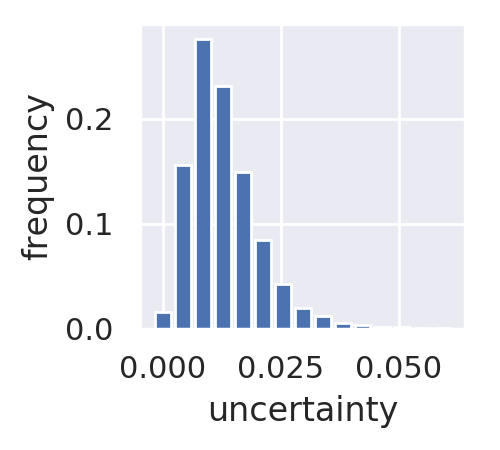

In [18]:
n_bins = 15
uce, err_in_bin, avg_uncert_in_bin, freq_in_bin = uceloss(err_calib**2, scaler(uncert_calib)**2, n_bins=n_bins)
plot_uncert(err_in_bin.cpu(), avg_uncert_in_bin.cpu())
plt.show()
print(uce.item()*100)
fig, ax = plot_frequency(scaler(uncert_calib).cpu(), freq_in_bin.cpu(), n_bins=n_bins)
fig.show()

<IPython.core.display.Javascript object>


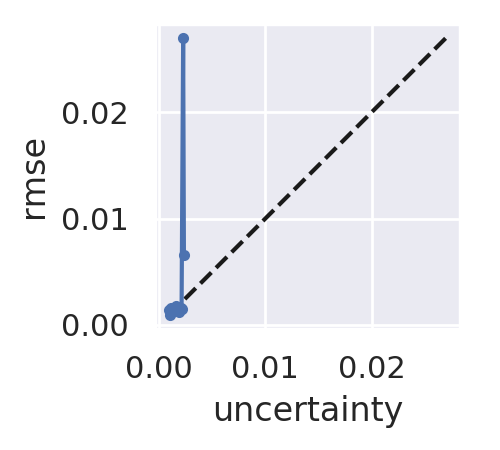

0.012800641707144678


In [19]:
uce, err_in_bin, avg_uncert_in_bin, freq_in_bin = uceloss(err_calib**2, aux(uncert_calib)**2, n_bins=n_bins)
plot_uncert(err_in_bin.cpu(), avg_uncert_in_bin.cpu())
plt.show()
print(uce.item()*100)

In [20]:
mus_test = []
vars_test = []
logvars_test = []
targets_test = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
        data, target = data.to(device), target.to(device)

        mu, logvar, var_bayesian = model(data, dropout=True, mc_dropout=True)

        mus_test.append(mu.detach())
        vars_test.append(var_bayesian.detach())
        logvars_test.append(logvar.detach())
        targets_test.append(target.detach())

    mu_test = torch.cat(mus_test, dim=0).clamp(0, 1)
    var_test = torch.cat(vars_test, dim=0)
    logvar_test = torch.cat(logvars_test, dim=0)
    target_test = torch.cat(targets_test, dim=0)

100%|██████████| 54/54 [01:07<00:00,  1.24s/it]


In [21]:
err_test = torch.pow(target_test-mu_test, 2).sqrt()

uncert_aleatoric_test = logvar_test.exp()
uncert_epistemic_test = var_test

if uncertainty == 'aleatoric':
    uncert_test = uncert_aleatoric_test.sqrt().clamp(0, 1)
elif uncertainty == 'epistemic':
    uncert_test = uncert_epistemic_test.sqrt().clamp(0, 1)
else:
    uncert_test = (uncert_aleatoric_test + uncert_epistemic_test).sqrt().clamp(0, 1)

In [22]:
print((err_test**2).mean())
print((uncert_test**2).mean())
print()

tensor(0.0007, device='cuda:0')
tensor(0.0004, device='cuda:0')



In [23]:
aux.train()
print(nll_criterion_gaussian(mu_test, uncert_test.pow(2).log(), target_test).item())
print(nll_criterion_gaussian(mu_test, (S*uncert_test).pow(2).log(), target_test).item())
print(nll_criterion_gaussian(mu_test, scaler(uncert_test).pow(2).log(), target_test).item())
print(nll_criterion_gaussian(mu_test, aux(uncert_test), target_test).item())
print()
aux.eval()

-5.991395950317383
-6.076413154602051
-6.0660505294799805
-6.072226524353027



AuxModel(
  (linear1): Linear(in_features=6, out_features=16, bias=True)
  (fc): Linear(in_features=16, out_features=6, bias=True)
)

In [24]:
print(torch.nn.functional.mse_loss(uncert_test**2, err_test**2, reduction='sum').item())
print(torch.nn.functional.mse_loss((S*uncert_test)**2, err_test**2, reduction='sum').item())
print(torch.nn.functional.mse_loss(scaler(uncert_test)**2, err_test**2, reduction='sum').item())
print(torch.nn.functional.mse_loss(aux(uncert_test)**2, err_test**2, reduction='sum').item())
print()

0.022006645798683167
0.023863403126597404
0.024092555046081543
0.023842252790927887



In [25]:
print(target_test.shape)
print(mu_test.shape)
print(uncert_test.shape)

torch.Size([850, 6])
torch.Size([850, 6])
torch.Size([850, 6])


## Compute prediction intervals

In [26]:
# compute sigma boundaries for 50%, 90%, 95% and 99% intervals

from scipy.special import erfinv

def probit(p):
    return erfinv(p)*np.sqrt(2)

expected_gamma = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99] #np.arange(0.1, 1.0, step=0.05)
#expected_gamma = np.arange(0.9, 1.0, step=0.01)
print(expected_gamma)
stds = [probit(i) for i in expected_gamma]
print(stds)

[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
[0.6744897501960817, 0.8416212335729143, 1.0364333894937898, 1.2815515655446004, 1.6448536269514722, 1.959963984540054, 2.5758293035489004]


In [27]:
# let's look at a sample
print(target_test[0])
print(mu_test[0])
print(uncert_test[0])

tensor([0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0.0699, 0.0449, 0.1196, 0.2461, 0.1240, 0.0320], device='cuda:0')
tensor([0.0214, 0.0243, 0.0263, 0.0301, 0.0253, 0.0220], device='cuda:0')


In [28]:
observed_gamma_uncal = []

print('uncal')
for std in stds:
    within = torch.logical_and(
        ((mu_test-std*uncert_test) < target_test),
        (target_test < (mu_test+std*uncert_test))
    ).sum().item()
    print(within/(target_test.shape[0]*target_test.shape[1]))
    observed_gamma_uncal.append(within/(target_test.shape[0]*target_test.shape[1]))

uncal
0.6441176470588236
0.6892156862745098
0.7321568627450981
0.7790196078431373
0.8337254901960784
0.8715686274509804
0.9217647058823529


In [29]:
observed_gamma_cal = {}

print('temp')
obs_gamma_current = []
for std in stds:
    within = torch.logical_and(
        ((mu_test-std*scaler(uncert_test)) < target_test),
        (target_test < (mu_test+std*scaler(uncert_test)))
    ).sum().item()
    print(within/(target_test.shape[0]*target_test.shape[1]))
    obs_gamma_current.append(within/(target_test.shape[0]*target_test.shape[1]))
observed_gamma_cal['temp'] = obs_gamma_current
print()

print('temp')
obs_gamma_current = []
for std in stds:
    within = torch.logical_and(
        ((mu_test-std*scaler(uncert_test)) < target_test),
        (target_test < (mu_test+std*scaler(uncert_test)))
    ).sum().item()
    print(within/(target_test.shape[0]*target_test.shape[1]))
    obs_gamma_current.append(within/(target_test.shape[0]*target_test.shape[1]))
observed_gamma_cal['temp'] = obs_gamma_current
print()

print('aux')
obs_gamma_current = []
for std in stds:
    within = torch.logical_and(
        ((mu_test-std*aux(uncert_test)) < target_test),
        (target_test < (mu_test+std*aux(uncert_test)))
    ).sum().item()
    print(within/(target_test.shape[0]*target_test.shape[1]))
    obs_gamma_current.append(within/(target_test.shape[0]*target_test.shape[1]))
observed_gamma_cal['aux'] = obs_gamma_current

temp
0.7843137254901961
0.8337254901960784
0.8792156862745099
0.917843137254902
0.9531372549019608
0.9701960784313726
0.9915686274509804

temp
0.7843137254901961
0.8337254901960784
0.8792156862745099
0.917843137254902
0.9531372549019608
0.9701960784313726
0.9915686274509804

aux
0.7860784313725491
0.8337254901960784
0.8764705882352941
0.9164705882352941
0.9525490196078431
0.9707843137254902
0.9907843137254903


In [30]:
import seaborn as sns

sns.set()
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{bm}']

<IPython.core.display.Javascript object>


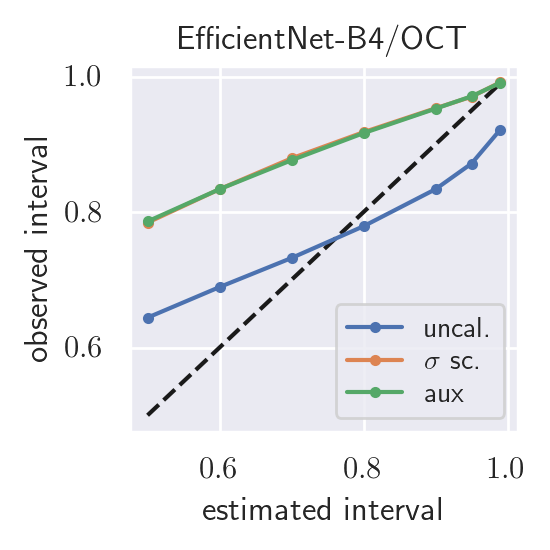

In [31]:
fig, ax = plt.subplots(1, figsize=(2.75, 2.75))
plt.plot([0.5, 0.99], [0.5, 0.99], 'k--')
plt.plot(expected_gamma, observed_gamma_uncal, '.-', label=r'uncal.')
plt.plot(expected_gamma, observed_gamma_cal['temp'], '.-', label=r'$ \sigma $ sc.')
plt.plot(expected_gamma, observed_gamma_cal['aux'], '.-', label='aux')
#if base_model == 'resnet101':
ax.legend(labelspacing=0.15, prop={'size': 10})
ax.set_xlabel(r'estimated interval')
ax.set_ylabel(r'observed interval')
ax.set_title(base_model_caps[base_model] + '/' + dataset)
fig.tight_layout()
fig.savefig("prediction_interval_"+ dataset +"_"+base_model+".pdf", bbox_inches='tight')
plt.show()